In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
from mushi.utils import prf
%config InlineBackend.figure_format = 'svg'

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [2]:
data_list = []

for i, f in enumerate(glob.glob('output/infer_eta/*/dat*')):
    data_list.append(pickle.load(open(f, 'rb')))

In [3]:
heatmap_data = []
for data in data_list:
    alpha_tv, alpha_spline, ksfs, eta_true = data
    if alpha_tv <= 5e3 and alpha_spline <= 1e4:
        loss = -prf(ksfs.mu.Z.sum(1), ksfs.X.sum(1), ksfs.L)
        error = ((np.log(eta_true.y) - np.log(ksfs.eta.y))**2).sum()
        heatmap_data.append([alpha_tv, alpha_spline, loss, error])

heatmap_data = np.array(heatmap_data)
heatmap_data = heatmap_data[np.lexsort(heatmap_data[:, 1::-1].T)]

/Users/williamdewitt/Applications/miniconda2/envs/mushidocs/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


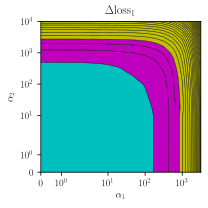

In [28]:
plt.figure(figsize=(3, 3))

x = np.unique(heatmap_data[:, 0])
y = np.unique(heatmap_data[:, 1])
z = heatmap_data[:, 2]
z0 = z[0]
Z = (z - z0).reshape(len(x), len(y)).T
norm = Normalize(vmin=100, vmax=600)
contour = plt.contour(x, y, Z, levels=40, norm=norm, colors='k', linewidths=.5)
plt.contourf(contour, levels=contour.levels[:2], colors='c')
plt.contourf(contour, levels=contour.levels[1:5], colors='m')
plt.contourf(contour, levels=contour.levels[4:], colors='y')
# plt.contourf(contour, levels=contour.levels[:2], colors='C0')
# heatmap = plt.contourf(contour, norm=norm, cmap='jet')
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
plt.title(r'$\Delta\mathrm{loss}_1$')
plt.tight_layout()

plt.savefig('eta_loss_map.pdf')

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
for i, data in enumerate(data_list):
    alpha_tv, alpha_spline, ksfs, eta_true = data
    delta_loss = -prf(ksfs.mu.Z.sum(1), ksfs.X.sum(1), ksfs.L) - z0
        
    if contour.levels[1] <= delta_loss <= contour.levels[4]:
        alpha = .75
        zorder = 2
        color = 'm'
        lw = 0.2
        rasterized = False
    elif delta_loss <= contour.levels[1]:
        alpha = .1
        zorder = 1
        color = 'c'
        lw = 1
        rasterized = True
    else:
        alpha = .02
        zorder = 1
        color = 'y'
        lw = 1
        rasterized = True

    plt.sca(ax1)
    ksfs.plot_total(kwargs=dict(alpha=0, rasterized=rasterized),
                    line_kwargs=dict(ls=':', marker='.', ms=3, alpha=alpha, zorder=zorder, lw=lw, c=color, rasterized=rasterized),
                    fill_kwargs=dict(alpha=0, rasterized=rasterized))
    plt.sca(ax2)
    ksfs.eta.plot(alpha=alpha, zorder=zorder, lw=lw, c=color, rasterized=rasterized)

plt.sca(ax1)
ksfs.plot_total(kwargs=dict(zorder=0, ls='', alpha=1, marker='o', ms=5, mew=.5, mfc='none', c='k', label=r'simulated SFS, $\mathbf x$'),
                line_kwargs=dict(alpha=0),
                fill_kwargs=dict(alpha=0))
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8, loc='upper right')

plt.sca(ax2)
eta_true.plot(c='k', alpha=1, ls='--', lw=1, label='true', zorder=1000)
plt.legend(fontsize=8, loc='upper right')
plt.xlim([1e1, 5e4])
plt.tight_layout()

plt.savefig('eta_models.pdf')